In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.11'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, Passengers                                                    |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 120
accelerator = 'auto'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (482, 2) , valid data shape:  (120, 2)


,date,ta
477,2021-04-22,168065
478,2021-04-23,158498
479,2021-04-24,170916
480,2021-04-25,167462
481,2021-04-26,151796


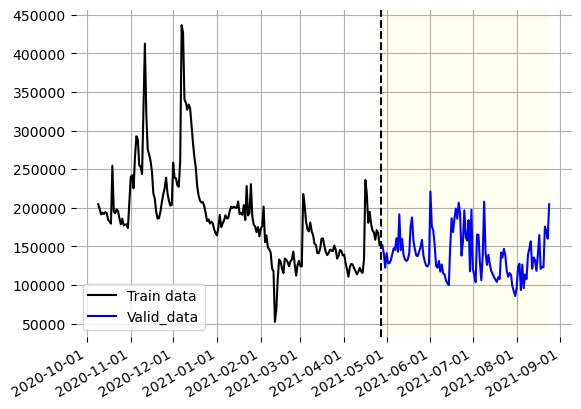

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data'],
    # date_fmt='%Y-%m-%d %H:%M:%S'  # 支持指定时间格式
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'd_linear',
 'gau',
 'lightgbm',
 'multi_output_model',
 'multi_step_model',
 'n_beats',
 'n_hits',
 'n_linear',
 'patch_rnn',
 'prophet',
 'random_forest',
 'regressor_chain',
 'stacking_rnn',
 'tcn',
 'tft',
 'tide',
 'time2vec',
 'transformer',
 'wide_gbrt',
 'xgboost']

In [9]:
# If you want to try multiple configurations of a model at once for comparison or tuning purposes, you can use `PipelineConfigs`.
# This feature allows for customizing the models returned by each `ModelPipeline.list_all_available_models()` call.
# The first one is the name of the model, which needs to be in the list of available models provided by PipelineTS.list_all_available_models(). 
# If you want to customize the name of the model, then the second argument can be a string of the model name, 
# otherwise, the second one is of type dict. The dict can have three keys: 'init_configs', 'fit_configs', 'predict_configs', or any combination of them. 
# The remaining keys will be automatically filled with default parameters.
# Among them, 'init_configs' represents the initialization parameters of the model, 'fit_configs' represents the parameters during model training, 
# and 'predict_configs' represents the parameters during model prediction.

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

pipeline_configs = PipelineConfigs([
    ('lightgbm', 'lightgbm_linear_tree', {'init_configs': {'verbose': -1, 'linear_tree': True}}),
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    ('multi_output_model', {
        'init_configs': {'estimator': XGBRegressor, 'random_state': 42, 'kwargs': {'verbosity': 0}}
    }
     ),
    ('multi_output_model', {
        'init_configs': {'estimator': CatBoostRegressor, 'random_state': 42, 'verbose': False}
    }
     ),
])

,model_name,model_name_after_rename,model_configs
0,lightgbm,lightgbm_linear_tree,"{'init_configs': {'verbose': -1, 'linear_tree': True}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
2,multi_output_model,multi_output_model_2,"{'init_configs': {'estimator': <class 'xgboost.sklearn.XGBRegressor'>, 'random_state': 42, 'kwargs': {'verbosity': 0}}, 'fit_configs': {}, 'predict_configs': {}}"
3,multi_output_model,multi_output_model_3,"{'init_configs': {'estimator': <class 'catboost.core.CatBoostRegressor'>, 'random_state': 42, 'verbose': False}, 'fit_configs': {}, 'predict_configs': {}}"
4,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


In [10]:
from sklearn.metrics import mean_absolute_error
pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    # configs=pipeline_configs, # default to None, it means use the default configs of the model
    include_init_config_model=False,
    scaler=None,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    include_models='all', # it can be one of the strings ‘light’, ‘all’, ‘nn’, or ‘ml’, or it is of type None or a list. Default to 'light'
    # include_models=['d_linear', 'random_forest', 'n_linear', 'n_beats'],  # specifying the model used
    # exclude_models=['catboost', 'tcn', 'transformer'],  # exclude specified models
    accelerator=accelerator,
    # Now we can directly input the "modelname__'init_params'" parameter to instantiate the models in ModelPipeline.
    # Note that it is double underline. 
    # When it is duplicated with the ModelPipeline class keyword parameter, the ModelPipeline class keyword parameter is ignored
    # such as :
    # d_linear__lags=50,
    # n_linear__random_state=1024,
    # n_beats__num_blocks=3,
    # random_forest__n_estimators=200
)

In [11]:
pipeline.fit(data, valid_data=valid_data)

2024-01-24 10:01:04 - PipelineTS - INFO - Information about the device used for computation:
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False


2024-01-24 10:01:05 - PipelineTS - INFO - There are a total of 22 models to be trained.
2024-01-24 10:01:05 - PipelineTS - INFO - [model  0] fitting and evaluating auto_arima...
2024-01-24 10:01:19 - PipelineTS - INFO - [model  1] fitting and evaluating catboost...
2024-01-24 10:03:20 - PipelineTS - INFO - [model  2] fitting and evaluating d_linear...
2024-01-24 10:03:40 - PipelineTS - INFO - [model  3] fitting and evaluating gau...
2024-01-24 10:04:01 - PipelineTS - INFO - [model  4] fitting and evaluating lightgbm...
2024-01-24 10:04:22 - PipelineTS - INFO - [model  5] fitting and evaluating multi_output_model...
2024-01-24 10:04:41 - PipelineTS - INFO - [model  6] fitting and evaluating multi_step_model...
2024-01-24 10:04:51 - P

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,tcn,5.878766,3.409662,16312.428320
1,wide_gbrt,37.146606,21.360000,23341.527006
2,n_linear,7.121169,3.203247,24834.870768
3,gau,11.495916,3.478865,26255.290397
4,d_linear,9.772166,3.623163,27470.806771
5,n_beats,25.913393,3.423749,27538.139388
6,tide,24.260704,3.391857,30246.024609
7,stacking_rnn,8.832985,3.560452,31129.826172
8,random_forest,2.619940,3.165073,39925.414833
9,prophet,0.247002,3.203016,43629.152945


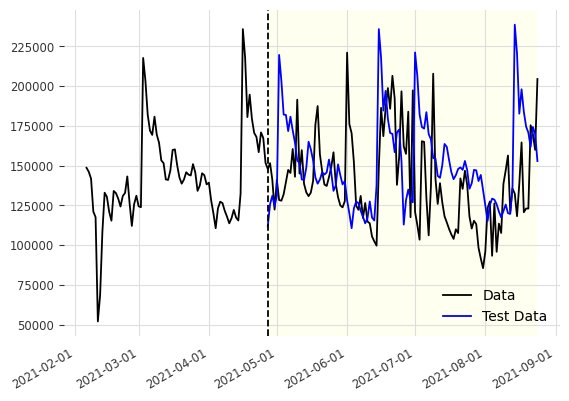

In [12]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col, labels=['Truth', 'Prediction'])

In [13]:
# Gets all configurations for the specified model， default to best model
pipeline.get_model_all_configs()

{'model_configs': {'kernel_size': 3,
  'dropout': 0.2,
  'learning_rate': 0.001,
  'random_seed': 42,
  'device': 'auto',
  'loss_fn': 'mae',
  'in_features': 60,
  'out_features': 60},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'quantile_error': 0,
 'verbose': False,
 'epochs': 1000,
 'batch_size': 'auto',
 'patience': 100,
 'min_delta': 0,
 'lr_scheduler': 'CosineAnnealingLR',
 'lr_scheduler_patience': 10,
 'lr_factor': 0.7,
 'restore_best_weights': True,
 'loss_type': 'min'}

## Model saving and reloading

In [14]:
from PipelineTS.io import *

In [15]:
save_model('pipeline.zip', pipeline)
pipeline2 = load_model('pipeline.zip')

In [16]:
pipeline2.best_model_

In [17]:
# Gets all configurations for the specified model， default to best model
pipeline2.get_model_all_configs()

{'model_configs': {'kernel_size': 3,
  'dropout': 0.2,
  'learning_rate': 0.001,
  'random_seed': 42,
  'device': 'auto',
  'loss_fn': 'mae',
  'in_features': 60,
  'out_features': 60},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'quantile_error': 0,
 'verbose': False,
 'epochs': 1000,
 'batch_size': 'auto',
 'patience': 100,
 'min_delta': 0,
 'lr_scheduler': 'CosineAnnealingLR',
 'lr_scheduler_patience': 10,
 'lr_factor': 0.7,
 'restore_best_weights': True,
 'loss_type': 'min'}

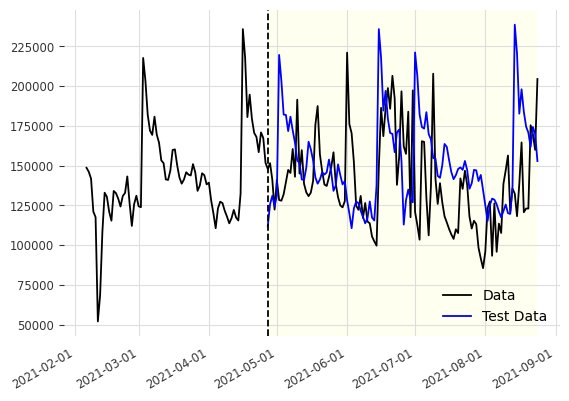

In [18]:
prediction = pipeline2.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col, labels=['Truth', 'Prediction'])